# Serial Handling

In [2]:
import time

import numpy as np
from com_handling import available_serial_ports, connect_COM_port
from setup_m import StartStopMeasurement, SystemMessageCallback

In [3]:
available_serial_ports()

['COM1', 'COM3', 'COM4']

In [4]:
ser = connect_COM_port("COM3", timeout=1)

Connection to COM3 is established.


In [5]:
SystemMessageCallback?

Signature:
SystemMessageCallback(
    serial,
    prnt_msg: bool = True,
    ret_hex_int: Optional[str] = None,
)
Docstring:
Reads the message buffer of a serial connection. Also prints out the general system message.
serial      ... serial connection
prnt_msg    ... print out the buffer
ret_hex_int ... Parameters -> ['none','hex', 'int', 'both']

@v=1.0.4
File:      c:\users\sciospeceit\desktop\sciospeceit\pyender\sciopy\setup_m.py
Type:      function


In [6]:
def GetFirmwareIDs(serial):
    """Get firmware IDs"""
    serial.write(bytearray([0xD2, 0x00, 0xD2]))
    SystemMessageCallback(serial)

In [7]:
GetFirmwareIDs(ser)

Command-Acknowledge: Command has been executed successfully
message buffer:
 ['0xd2', '0x1e', '0x1', '0x11', '0x0', '0x19', '0x0', '0xb', '0x40', '0x0', '0x9', '0x0', '0x25', '0x2', '0xc9', '0x0', '0xf', '0x1', '0x11', '0x0', '0x19', '0x0', '0xb', '0x40', '0x0', '0x9', '0x0', '0x25', '0x2', '0xc9', '0x0', '0xf', '0xd2', '0x18', '0x1', '0x83', '0x18']
message length:	 37


In [6]:
from default_configurations import configuration_01

In [8]:
configuration_01(ser)  # tbd in ender gui
SystemMessageCallback(ser)

Command-Acknowledge: Command has been executed successfully
message buffer:
 ['0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', 

In [10]:
# Write burst count
ser.write(bytearray([0xB0, 0x03, 0x02, 0x00, 0x01, 0xB0]))

6

In [11]:
SystemMessageCallback(ser)

Command-Acknowledge: Command has been executed successfully
message buffer:
 ['0x18', '0x1', '0x83', '0x18']
message length:	 4


In [12]:
measurement_data_hex = StartStopMeasurement(ser)

Command-Acknowledge: Command has been executed successfully
Stopping measurement:
Command-Acknowledge: Command has been executed successfully


In [13]:
print(len(measurement_data_hex))

print(measurement_data_hex[:10])
print(measurement_data_hex[len(measurement_data_hex) - 10 :])

17924
['0x18', '0x1', '0x83', '0x18', '0xb4', '0x89', '0x1', '0x1', '0x2', '0x0']
['0xde', '0xb5', '0xff', '0xaf', '0x95', '0xb5', '0xf7', '0x5d', '0xde', '0xb4']


In [84]:
# np.save('hex_bc_200.npy', measurement_data_hex)

# Hexcallback

In [7]:
import struct
from dataclasses import dataclass
from typing import List, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np

In [8]:
def del_hex_in_list(lst: list) -> list:
    return [
        "0" + ele.replace("0x", "") if len(ele) == 1 else ele.replace("0x", "")
        for ele in lst
    ]


def bytesarray_to_float(bytes_array: np.ndarray) -> float:
    bytes_array = [int(b, 16) for b in bytes_array]
    bytes_array = bytes(bytes_array)
    return struct.unpack("!f", bytes(bytes_array))[0]


def bytesarray_to_int(bytes_array: np.ndarray) -> int:
    bytes_array = bytesarray_to_byteslist(bytes_array)
    return int.from_bytes(bytes_array, "big")


def bytesarray_to_byteslist(bytes_array: np.ndarray) -> list:
    bytes_array = [int(b, 16) for b in bytes_array]
    return bytes(bytes_array)


def reshape_measurement_buffer(lst: list) -> np.ndarray:
    idx_b4 = [i for i, ele in enumerate(lst) if ele == "b4"]
    idx_b4 = np.array(idx_b4)
    step = abs(idx_b4[1] - idx_b4[0]) + 1
    return np.array(
        [lst[i : i + step] for i in range(idx_b4[0], idx_b4[-1] + step, step)],
        dtype=list,
    )[:-1]


@dataclass
class BaseSettingForEstimation:
    active_channel_groups: np.ndarray
    burst_count: int


@dataclass
class SingleFrame:
    start_tag: List[str]
    channel_group: str
    excitation_stgs: List[str]
    frequency_row: List[str]
    timestamp: int  # [ms]
    ch_1: complex
    ch_2: complex
    ch_3: complex
    ch_4: complex
    ch_5: complex
    ch_6: complex
    ch_7: complex
    ch_8: complex
    ch_9: complex
    ch_10: complex
    ch_11: complex
    ch_12: complex
    ch_13: complex
    ch_14: complex
    ch_15: complex
    ch_16: complex
    end_tag: str


def parse_single_frame(lst_ele: np.ndarray) -> SingleFrame:
    channels = {}
    enum = 0
    for i in range(11, 135, 8):
        enum += 1
        channels[f"ch_{enum}"] = complex(
            bytesarray_to_float(lst_ele[i : i + 4]),
            bytesarray_to_float(lst_ele[i + 4 : i + 8]),
        )

    excitation_stgs = np.array([ele for ele in lst_ele[3:5]])

    sgl_frm = SingleFrame(
        start_tag=lst_ele[0],
        channel_group=int(lst_ele[2]),
        excitation_stgs=excitation_stgs,
        frequency_row=lst_ele[5:7],
        timestamp=bytesarray_to_int(lst_ele[7:11]),
        **channels,
        end_tag=lst_ele[139],
    )
    return sgl_frm

In [3]:
# base_stgs_for_est = BaseSettingForEstimation(np.array([1]), 1)
# base_stgs_for_est
from sciopy.sciopy_dataclasses import ScioSpecMeasurementConfig

In [25]:
measurement_data_hex = np.load("tmp_data/Sample0.npy.npz", allow_pickle=True)
measurement_data_hex.files

['config', 'data', 'allow_pickle']

In [26]:
measurement_data_hex["config"].tolist()

ScioSpecMeasurementConfig(sample_per_step=10, actual_sample=0, s_path='tmp_data/', object='circle')

In [27]:
measurement_data_hex["data"]

array(['18', '1', '82', '18'], dtype='<U2')

In [4]:
lst = del_hex_in_list(measurement_data_hex)  # tmp["data_hex"]

NameError: name 'measurement_data_hex' is not defined

In [18]:
l = reshape_measurement_buffer(lst)

In [19]:
def get_channel_group_img(reshaped_measurement_buffer: np.ndarray, channel_grout: int):
    img = np.empty((0, 16))
    for i, sf in enumerate(reshaped_measurement_buffer):
        tmp_f = parse_single_frame(sf)
        if tmp_f.channel_group == channel_grout:
            tmp_f = tmp_f.__dict__
            tmp_row = np.array([tmp_f[f"ch_{ch_n}"] for ch_n in range(1, 17)])
            img = np.vstack((img, abs(tmp_row)))
    img = np.delete(np.matrix(img), 0, axis=0)
    print("Shape:", img.shape)
    return img

Shape: (31, 16)


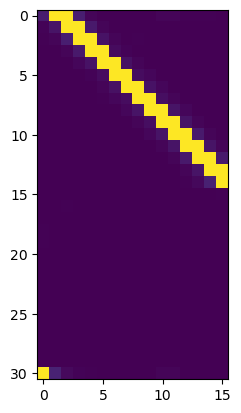

In [20]:
plt.imshow(get_channel_group_img(l, 1))

# Save data to pickle

In [46]:
import pickle
from typing import Union

from ender_sciospec_classes import CircleDrivePattern, KartesianDrivePattern
from sciopy.sciopy_dataclasses import ScioSpecMeasurementConfig


def split_pickle_to_classes(
    pkl_data: list,
) -> Union[ScioSpecMeasurementConfig, CircleDrivePattern, KartesianDrivePattern]:

    return pkl_data[0], pkl_data[1], pkl_data[2]

In [47]:
with open("meas_cnf.pkl", "rb") as f:
    meas_cnf = pickle.load(f)

In [50]:
scio_spec_measurement_config,circledrivepattern,kartesiandrivepattern = split_pickle_to_classes(meas_cnf)

In [58]:
scio_spec_measurement_config

ScioSpecMeasurementConfig(sample_per_step=10, actual_sample=0, s_path='tmp_data/', object='circle')

In [52]:
circledrivepattern

CircleDrivePattern(active=True, wait_at_pos=1, radius=100, phi_steps=10, abs_x_posis=array([280.        , 278.4807753 , 273.96926208, 266.60254038,
       256.60444431, 244.27876097, 230.        , 214.20201433,
       197.36481777, 180.        , 162.63518223, 145.79798567,
       130.        , 115.72123903, 103.39555569,  93.39745962,
        86.03073792,  81.5192247 ,  80.        ,  81.5192247 ,
        86.03073792,  93.39745962, 103.39555569, 115.72123903,
       130.        , 145.79798567, 162.63518223, 180.        ,
       197.36481777, 214.20201433, 230.        , 244.27876097,
       256.60444431, 266.60254038, 273.96926208, 278.4807753 ]), abs_y_posis=array([180.        , 197.36481777, 214.20201433, 230.        ,
       244.27876097, 256.60444431, 266.60254038, 273.96926208,
       278.4807753 , 280.        , 278.4807753 , 273.96926208,
       266.60254038, 256.60444431, 244.27876097, 230.        ,
       214.20201433, 197.36481777, 180.        , 162.63518223,
       145.79798567

In [56]:
kartesiandrivepattern.abs_x_posis

array([0.])